#### In this notebook we explore the correlation coefficient between ensemble ARMA time series and the original FMRI time series.

In [1]:
import pingouin as pg
import pandas as pd
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
import seaborn
import math


D:\anaconda\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.6.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Reading in Files

In [48]:
# Reading in Rscore files by stack and concatenate them
runs = ['run1','run2','run3','run4']
all_Rscore = []

for run in runs:
    file = 'E:/projects/connectome/results/'+run+'/Rscore/Rscore_1.csv'
    Rscore = pd.read_csv(file)
    Rscore = Rscore.rename(columns={'Unnamed: 0':'ID'})
    Rscore = Rscore.set_index('ID')
    for i in range(2,21):
        file = 'E:/projects/connectome/results/'+run+'/Rscore/Rscore_'+str(i)+'.csv'
        tmp2 = pd.read_csv(file)
        tmp2 = tmp2.rename(columns={'Unnamed: 0':'ID'})
        tmp2 = tmp2.set_index('ID')
        Rscore = pd.concat([Rscore, tmp2],sort=True)

    # sort regions by region number
    for reg in Rscore:
        Rscore = Rscore.rename(columns={reg:int(reg.strip('region '))})
    Rscore = Rscore.sort_index(axis=1)
    for reg in Rscore:
        Rscore = Rscore.rename(columns={reg:'region '+str(reg)})
    
    # sort by subject ID and save to file
    Rscore.to_csv('E:/projects/connectome/results/'+run+'/Rscore/Rscore_all.csv',index=True)
    
    all_Rscore.append(Rscore)

In [35]:
len(set(all_Rscore[2].index))

820

Visualize with heatmap

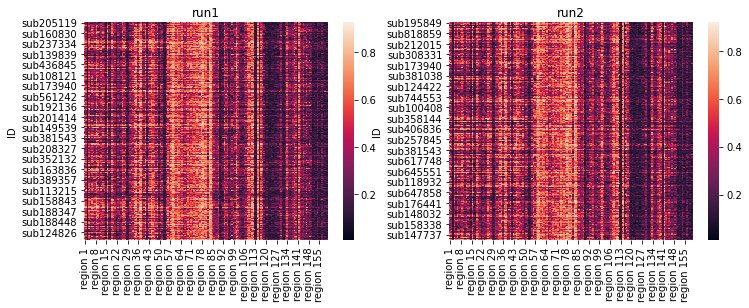

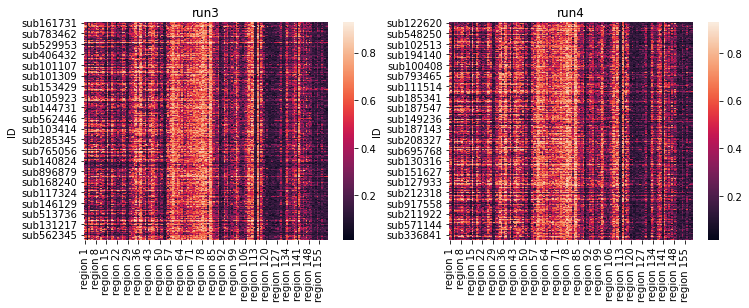

In [49]:
for i in range(2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    seaborn.heatmap(all_Rscore[2*i],ax=axes[0])
    seaborn.heatmap(all_Rscore[2*i+1],ax=axes[1])
    axes[0].title.set_text('run'+str(i*2+1))
    axes[1].title.set_text('run'+str(i*2+2))
    plt.show()

# Performing Significance Tests

#### Since some regions negative correlations, even though there is only a small number of those, we want to see if the mean of each regions are still significant. Once this is established, we set out to use the absolute correlation. 

In [37]:
for j in range(4):
    ttests = [] # whether the mean of correlations of each region is siginificant from zero
    for i in range(1,161):
        reg = 'region '+str(i)
        ttests.append(scipy.stats.ttest_1samp(all_Rscore[j][reg],0))
    
    ttest_significant = []
    for ttest in ttests:
        ttest_significant.append(ttest[1]<0.01)
    print("By T-tests, the number of significant regions in run{} is: {}".format(j+1,sum(ttest_significant)))

By T-tests, the number of significant regions in run1 is: 160
By T-tests, the number of significant regions in run2 is: 160
By T-tests, the number of significant regions in run3 is: 160
By T-tests, the number of significant regions in run4 is: 160


In [38]:
for j in range(4):
    wtests = [] # whether the mean of correlations of each region is siginificant from zero
    for i in range(1,161):
        reg = 'region '+str(i)
        wtests.append(scipy.stats.wilcoxon(all_Rscore[j][reg]))
    
    wtest_significant = []
    for wtest in wtests:
        wtest_significant.append(wtest[1]<0.01)
    print("By Wilcoxon tests, the number of significant regions in run{} is: {}".format(j+1,sum(wtest_significant)))

By Wilcoxon tests, the number of significant regions in run1 is: 160
By Wilcoxon tests, the number of significant regions in run2 is: 160
By Wilcoxon tests, the number of significant regions in run3 is: 160
By Wilcoxon tests, the number of significant regions in run4 is: 160


# Compute Average Correlation

#### We will utilize seven different variance stabilizing transformations to facilitate the computation of average correlations. Brute force arithmetic averaging would not make much sense statistically. The easiet example of arithmetically averaging correlations to produce non-sensical result is r1=0.5 and r2=-0.5. In fact, since correlations are not normally distributed, we cannot take arithmetic average. By using stabilizing transformations, we wish to make the distribution of our correlations closer to normal (yet still not quite as indicated by the normality test). At least, now  the averages obtained would not sound as absurd. 

In [39]:
# Ideas of the following VST's: (1) transform data (2)compute average for the transformed data (3)inverse-transform the average
def fisherAvg(corrs):
    z = 0.5*np.log((1+corrs)/(1-corrs))
    avg_z = sum(z)/len(corrs)
    return (math.exp(2*avg_z) - 1) / (math.exp(2*avg_z) + 1)

def squareAvg(corrs):
    return math.sqrt(sum(corrs**2)/len(corrs))

def rootAvg(corrs):
    return (sum(corrs**0.5)/len(corrs))**2

def arccosAvg(corrs):
    return np.cos(sum(np.arccos(corrs))/len(corrs))

def harmonicAvg(corrs):
    return 1/(sum(1/np.arcsin(corrs))/len(corrs))

def geomAvg(corrs):
    return np.exp(sum(np.log(corrs))/len(corrs))

def arsinhAvg(corrs):
    return np.sum(np.log(corrs+(corrs**2+1)**0.5))/len(corrs)

#### These three averaging methods only work for positive correlations

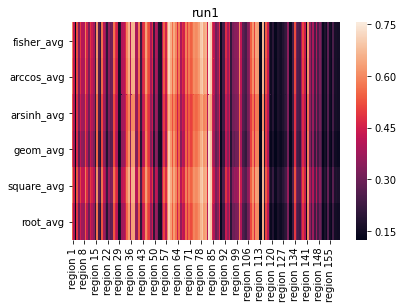

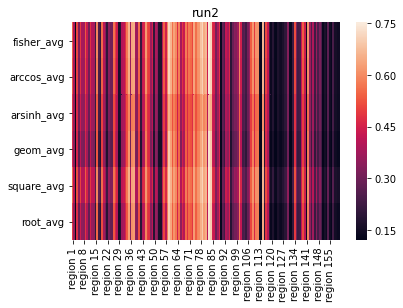

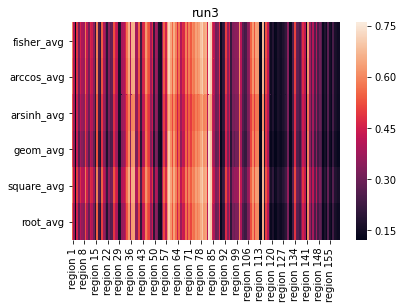

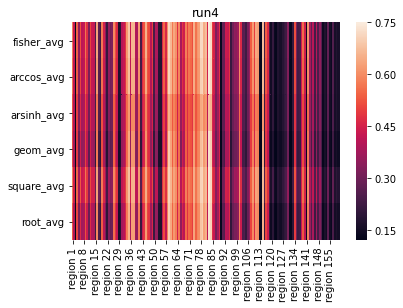

In [40]:
averages = []

for j in range(4):
    fisher_avg = []
    square_avg = []
    root_avg = []
    arccos_avg = []
    geom_avg = []
    harmonic_avg = []
    arsinh_avg = []
    for i in range(1,161):
        reg = 'region '+str(i)
        fisher_avg.append(fisherAvg(all_Rscore[j][reg]))
        square_avg.append(squareAvg(all_Rscore[j][reg]))
        root_avg.append(rootAvg(all_Rscore[j][reg]))
        arccos_avg.append(arccosAvg(all_Rscore[j][reg]))
        harmonic_avg.append(harmonicAvg(all_Rscore[j][reg]))
        geom_avg.append(geomAvg(all_Rscore[j][reg]))
        arsinh_avg.append(arsinhAvg(all_Rscore[j][reg]))
    avg_corr_dict = {}
    for i in range(160):
        reg = 'region '+str(i+1)
        avg_corr_dict[reg] = [square_avg[i]]
    square_avg = pd.DataFrame(avg_corr_dict,index=['square_avg'])

    avg_corr_dict = {}
    for i in range(160):
        reg = 'region '+str(i+1)
        avg_corr_dict[reg] = [root_avg[i]]
    root_avg = pd.DataFrame(avg_corr_dict,index=['root_avg'])

    avg_corr_dict = {}
    for i in range(160):
        reg = 'region '+str(i+1)
        avg_corr_dict[reg] = [geom_avg[i]]
    geom_avg = pd.DataFrame(avg_corr_dict,index=['geom_avg'])
    
    avg_corr_dict = {}
    for i in range(160):
        reg = 'region '+str(i+1)
        avg_corr_dict[reg] = [fisher_avg[i]]
    fisher_avg = pd.DataFrame(avg_corr_dict,index=['fisher_avg'])

    avg_corr_dict = {}
    for i in range(160):
        reg = 'region '+str(i+1)
        avg_corr_dict[reg] = [arccos_avg[i]]
    arccos_avg = pd.DataFrame(avg_corr_dict,index=['arccos_avg'])


    avg_corr_dict = {}
    for i in range(160):
        reg = 'region '+str(i+1)
        avg_corr_dict[reg] = [arsinh_avg[i]]
    arsinh_avg = pd.DataFrame(avg_corr_dict,index=['arsinh_avg'])
    
    averages.append(pd.concat([fisher_avg,arccos_avg,arsinh_avg,geom_avg,square_avg,root_avg],axis=0))
    
    seaborn.heatmap(averages[-1])
    plt.title('run'+str(j+1))
    plt.show()

# Tests for Regions with High Correlation

In [41]:
for k in range(4):
    ttests = [] # whether the mean of correlations of each region is siginificant from zero
    for i in range(1,161):
        reg = 'region '+str(i)
        ttests.append(scipy.stats.ttest_1samp(all_Rscore[k][reg],0.5))
    
    print('For run'+str(k+1))
    for j in range(5,10): 
        ttest_high_corr = []
        for i,ttest in enumerate(ttests):
            if fisher_avg['region '+str(i+1)].loc['fisher_avg']>j/10 and ttest[1]<0.05:
                ttest_high_corr.append(1)
            else:
                ttest_high_corr.append(0)
        print("By T-tests, the number of regions with average correlation greater than {} is: {}".format(j/10,sum(ttest_high_corr)))

For run1
By T-tests, the number of regions with average correlation greater than 0.5 is: 48
By T-tests, the number of regions with average correlation greater than 0.6 is: 27
By T-tests, the number of regions with average correlation greater than 0.7 is: 5
By T-tests, the number of regions with average correlation greater than 0.8 is: 0
By T-tests, the number of regions with average correlation greater than 0.9 is: 0
For run2
By T-tests, the number of regions with average correlation greater than 0.5 is: 45
By T-tests, the number of regions with average correlation greater than 0.6 is: 27
By T-tests, the number of regions with average correlation greater than 0.7 is: 5
By T-tests, the number of regions with average correlation greater than 0.8 is: 0
By T-tests, the number of regions with average correlation greater than 0.9 is: 0
For run3
By T-tests, the number of regions with average correlation greater than 0.5 is: 50
By T-tests, the number of regions with average correlation greater

# Extract the Regions with the Highest Correlations

In [42]:
top_n = 15 # top 10 regions with the highest correlations to the original time-series
col_names = ['top '+str(i+1) for i in range(top_n)] 
top_n_regions = pd.DataFrame(columns=col_names) # get the most correlated regions out based on each averaging methods

In [43]:
top_n_regions_for_run = []
for k in range(4):
    avg_methods = ['arccos_avg','fisher_avg','arsinh_avg']

    top_n_regions = []
    for j,avg_method in enumerate(avg_methods):
        tmp = {}
        # use double brackets [[]] in .loc to extract a row/columns in the form of dataframe;
        # otherwise, if used only single bracket [], that row would be extracted a series a lose index/column names 
        sorted_avg = averages[k].loc[[avg_method]].T.sort_values(by=avg_method,ascending=False)[:top_n].T
        cols = sorted_avg.columns
        for i,col in enumerate(cols):
            # to create a dataframe with tuple entries, wrap the tuples in a list
            # so dict[key]=[(tuple)] then pd.DataFrame(dict) 
            tmp['top '+str(i+1)]=[(col,round(sorted_avg[col].values[0],3))] # round the correlation to 3 decimal digits
        tmp = pd.DataFrame(tmp,index=[avg_method])
        top_n_regions.append(tmp)
        
    top_n_regions = pd.concat(top_n_regions,axis=0)
    top_n_regions_for_run.append(top_n_regions)

In [44]:
top_n_regions_for_run[0]

,top 1,top 2,top 3,top 4,top 5,top 6,top 7,top 8,top 9,top 10,top 11,top 12,top 13,top 14,top 15
arccos_avg,"(region 83, 0.749)","(region 59, 0.711)","(region 84, 0.708)","(region 79, 0.705)","(region 78, 0.688)","(region 115, 0.661)","(region 38, 0.658)","(region 81, 0.654)","(region 37, 0.653)","(region 35, 0.649)","(region 60, 0.647)","(region 80, 0.64)","(region 62, 0.64)","(region 111, 0.626)","(region 77, 0.626)"
fisher_avg,"(region 83, 0.755)","(region 59, 0.718)","(region 84, 0.715)","(region 79, 0.713)","(region 78, 0.699)","(region 115, 0.668)","(region 38, 0.668)","(region 37, 0.664)","(region 81, 0.662)","(region 35, 0.661)","(region 60, 0.656)","(region 80, 0.647)","(region 62, 0.647)","(region 111, 0.638)","(region 45, 0.634)"
arsinh_avg,"(region 83, 0.687)","(region 59, 0.654)","(region 84, 0.651)","(region 79, 0.648)","(region 78, 0.629)","(region 115, 0.613)","(region 81, 0.606)","(region 38, 0.605)","(region 37, 0.601)","(region 60, 0.598)","(region 35, 0.596)","(region 62, 0.594)","(region 80, 0.593)","(region 77, 0.581)","(region 111, 0.577)"


In [45]:
top_n_regions_for_run[1]

,top 1,top 2,top 3,top 4,top 5,top 6,top 7,top 8,top 9,top 10,top 11,top 12,top 13,top 14,top 15
arccos_avg,"(region 83, 0.746)","(region 84, 0.712)","(region 79, 0.709)","(region 59, 0.709)","(region 78, 0.673)","(region 81, 0.662)","(region 115, 0.658)","(region 60, 0.655)","(region 35, 0.649)","(region 38, 0.641)","(region 80, 0.639)","(region 74, 0.637)","(region 37, 0.631)","(region 62, 0.627)","(region 77, 0.612)"
fisher_avg,"(region 83, 0.752)","(region 84, 0.718)","(region 79, 0.717)","(region 59, 0.716)","(region 78, 0.685)","(region 81, 0.669)","(region 115, 0.666)","(region 60, 0.664)","(region 35, 0.661)","(region 38, 0.651)","(region 80, 0.647)","(region 74, 0.643)","(region 37, 0.642)","(region 62, 0.635)","(region 77, 0.62)"
arsinh_avg,"(region 83, 0.684)","(region 84, 0.655)","(region 59, 0.652)","(region 79, 0.652)","(region 78, 0.616)","(region 81, 0.613)","(region 115, 0.61)","(region 60, 0.606)","(region 35, 0.596)","(region 80, 0.593)","(region 74, 0.592)","(region 38, 0.592)","(region 62, 0.583)","(region 37, 0.582)","(region 77, 0.57)"


In [46]:
top_n_regions_for_run[2]

,top 1,top 2,top 3,top 4,top 5,top 6,top 7,top 8,top 9,top 10,top 11,top 12,top 13,top 14,top 15
arccos_avg,"(region 83, 0.753)","(region 84, 0.714)","(region 59, 0.71)","(region 79, 0.707)","(region 78, 0.677)","(region 115, 0.666)","(region 38, 0.654)","(region 81, 0.653)","(region 62, 0.649)","(region 37, 0.648)","(region 35, 0.646)","(region 80, 0.639)","(region 60, 0.637)","(region 75, 0.631)","(region 77, 0.63)"
fisher_avg,"(region 83, 0.759)","(region 84, 0.72)","(region 59, 0.717)","(region 79, 0.714)","(region 78, 0.69)","(region 115, 0.673)","(region 38, 0.665)","(region 81, 0.661)","(region 37, 0.66)","(region 35, 0.659)","(region 62, 0.657)","(region 80, 0.646)","(region 60, 0.646)","(region 75, 0.639)","(region 77, 0.638)"
arsinh_avg,"(region 83, 0.69)","(region 84, 0.656)","(region 59, 0.653)","(region 79, 0.65)","(region 78, 0.62)","(region 115, 0.616)","(region 81, 0.604)","(region 38, 0.602)","(region 62, 0.602)","(region 37, 0.596)","(region 35, 0.594)","(region 80, 0.593)","(region 60, 0.59)","(region 75, 0.585)","(region 77, 0.584)"


In [47]:
top_n_regions_for_run[3]

,top 1,top 2,top 3,top 4,top 5,top 6,top 7,top 8,top 9,top 10,top 11,top 12,top 13,top 14,top 15
arccos_avg,"(region 83, 0.744)","(region 84, 0.719)","(region 79, 0.714)","(region 59, 0.71)","(region 78, 0.706)","(region 35, 0.675)","(region 81, 0.667)","(region 115, 0.665)","(region 60, 0.659)","(region 38, 0.651)","(region 37, 0.65)","(region 74, 0.648)","(region 80, 0.643)","(region 45, 0.643)","(region 62, 0.633)"
fisher_avg,"(region 83, 0.75)","(region 84, 0.726)","(region 79, 0.722)","(region 78, 0.718)","(region 59, 0.717)","(region 35, 0.687)","(region 81, 0.675)","(region 115, 0.672)","(region 60, 0.668)","(region 37, 0.662)","(region 38, 0.662)","(region 74, 0.655)","(region 45, 0.654)","(region 80, 0.651)","(region 111, 0.641)"
arsinh_avg,"(region 83, 0.682)","(region 84, 0.661)","(region 79, 0.655)","(region 59, 0.653)","(region 78, 0.643)","(region 35, 0.618)","(region 115, 0.616)","(region 81, 0.616)","(region 60, 0.609)","(region 74, 0.602)","(region 38, 0.598)","(region 37, 0.598)","(region 80, 0.596)","(region 45, 0.591)","(region 62, 0.587)"


# Variance of Correlations

In [28]:
variance = [] # variance of the correlations of each region
for i in range(1,161):
    reg = 'region '+str(i)
    variance.append(np.var(Rscore[reg]))

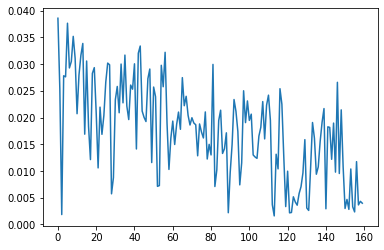

In [43]:
plt.plot(variance)
plt.show()

# Plotting the Ensemble Time-series on top of the Original

In [72]:
def plotTS(sub,reg,start,end):
    # sub: subject ID
    # reg: region number
    # start, end: starting point and end point of the time-series that is to be plotted
    fitted_file = 'E:/projects/connectome/results/run2/HurstExp_ARMA_results_0_to_5/ensemble_ts/ensemble_ts_'+str(sub)+'.mat'
    fitted_matrix = scipy.io.loadmat(fitted_file)
    fitted_ts = fitted_matrix['ensemble_ts'][reg-1][start:end]
    original_file = 'E:/projects/connectome/data/FMRI_820subs/run2/DOS160_TC_HCP_REST1RL_'+str(sub)+'.mat'
    original_matrix = scipy.io.loadmat(original_file)
    original_ts = original_matrix['tc'][:,reg-1][start:end]
    plt.plot(fitted_ts, color='g',label='fitted_ensemble')
    plt.plot(original_ts, color='r', label='original' )
    plt.legend()
    plt.show()

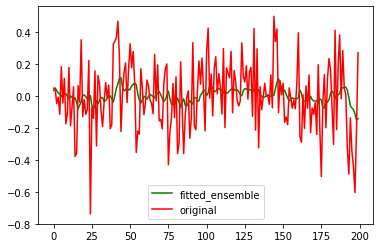

In [73]:
plotTS(173940,100,400,600)